In [1]:
import sys, os
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
# from svgd import SVGD

BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
print(BASE_DIR)
sys.path.insert(1, BASE_DIR)


/Users/mahrokh/Simulations/perf-boost-PAC


In [2]:
import torch

class Gaussian:
    def __init__(self, mu, std):
        self.mu = mu
        self.std = std

    def mean(self):
        return self.mu

    def var(self):
        return self.std**2

    def pdf(self, x):
        return 1/self.std/(2*torch.pi)**0.5*torch.exp(-(x-self.mu)**2/2/self.std**2)
        
class MixedGaussian:
    def __init__(self, use_np):
        self.use_np = use_np
        # define distributions
        if not self.use_np:
            self.d1 = Gaussian(1.5, 0.6)
            self.d2 = Gaussian(5, 1.1)
        else:
            self.d1 = stats.norm(1.5, 0.6)
            self.d2 = stats.norm(5, 1.1)

        # set mixture component weights
        if not self.use_np:
            self.mc = torch.Tensor([0.3, 0.7])
            self.mc = self.mc / torch.sum(self.mc) # ensuring they sum to 1
        else:
            self.mc = [0.3, 0.7]
            self.mc = self.mc / np.sum(self.mc) # ensuring they sum to 1

    def pdf(self, x):
        # calculate density and apply mixture weights
        c1 = self.d1.pdf(x) * self.mc[0]
        c2 = self.d2.pdf(x) * self.mc[1]
        return c1+c2

    def d_pdf(self, x):
        # calculate d/dx density and apply mixture weights
        d_c1 = self.d1.pdf(x)*(self.d1.mean() - x)/self.d1.var() * self.mc[0]
        d_c2 = self.d2.pdf(x)*(self.d2.mean() - x)/self.d2.var() * self.mc[1]
        return d_c1+d_c2
    
    def log_prob(self, x):
        if not self.use_np:
            return torch.log(self.pdf(x))
        else:
            return np.log(self.pdf(x))

    def d_log_prob(self, x):
        return 1/self.pdf(x) * self.d_pdf(x)

target_np = MixedGaussian(use_np=True)
target_tr = MixedGaussian(use_np=False)


In [3]:
from scipy.spatial.distance import pdist, squareform

class SVGD():

    def __init__(self, h=-1):
        self.h=h
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))
            
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = self.h)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
            
        return theta
    

In [4]:
green_color = "#50C878"
red_color = (218/255, 114/255, 107/255) #"#F19C99" #"#c44e52" 
purple_color = (108/255, 78/255, 113/255) # "#6B4E71"
blue_color =  (134/255, 165/255, 219/255) #"#CCE5FF"  #  "#4c72b0" #

In [5]:
num_particles = 10
x_plot = np.linspace(-2, 8, 501)

# x0 = np.random.normal((x_plot[0]+x_plot[-1])/2, 3, [num_particles, 1])
x0=np.linspace(x_plot[0], x_plot[-1], num_particles)
theta = SVGD().update(x0.reshape(-1,1), target_np.d_log_prob, n_iter=10000, stepsize=0.1)


# Normalizing Flows


Iter 0 --- NF Loss = 10.231557846069336 (best so far)


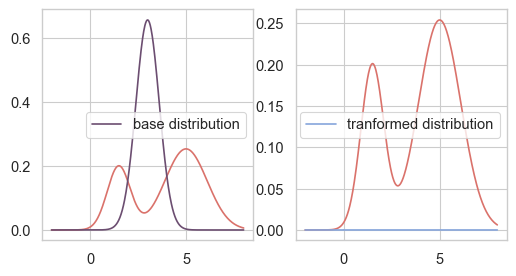

Iter 500 --- NF Loss = 4.845357894897461 (best so far)


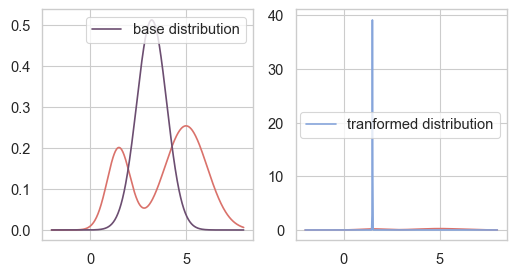

Iter 1000 --- NF Loss = 2.025257110595703 (best so far)


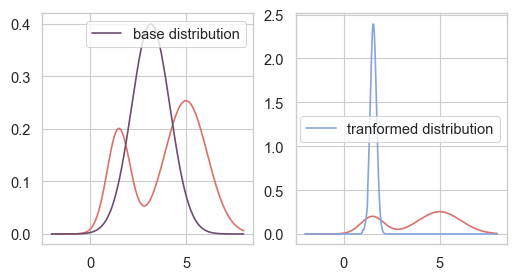

Iter 1500 --- NF Loss = 1.2161829471588135 (best so far)


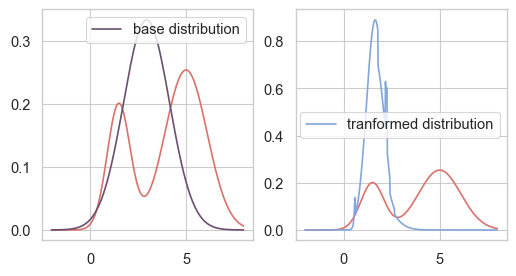

Iter 2000 --- NF Loss = 0.4579763412475586 (best so far)


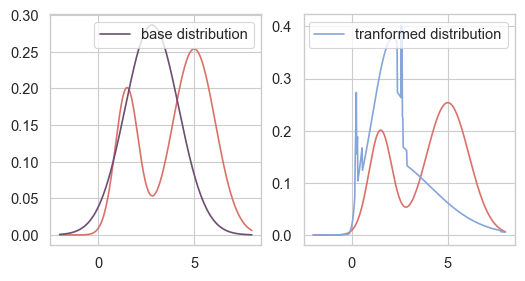

Iter 2500 --- NF Loss = 0.6449998617172241


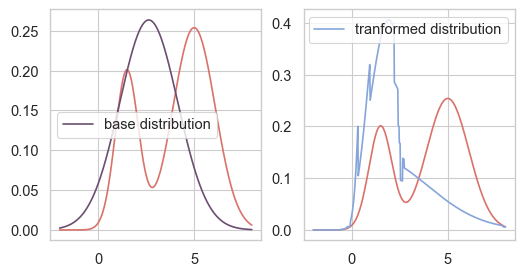

Iter 3000 --- NF Loss = 0.55292809009552


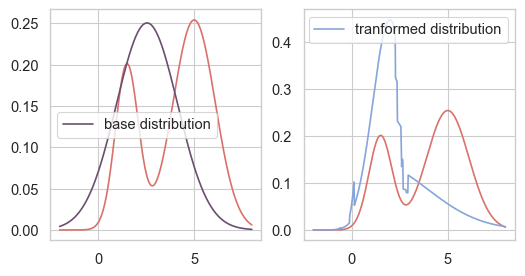

Iter 3500 --- NF Loss = 0.3772205114364624 (best so far)


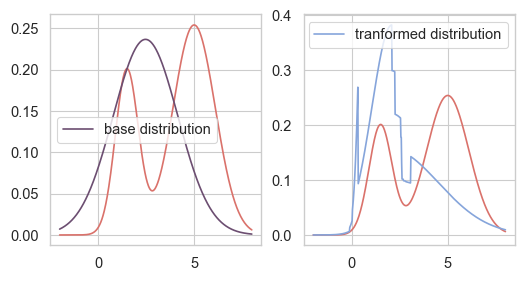

Iter 4000 --- NF Loss = 0.23378193378448486 (best so far)


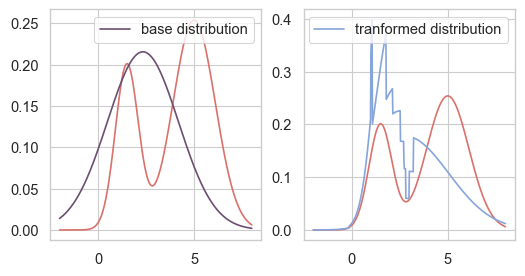

Iter 4500 --- NF Loss = 0.12317585945129395 (best so far)


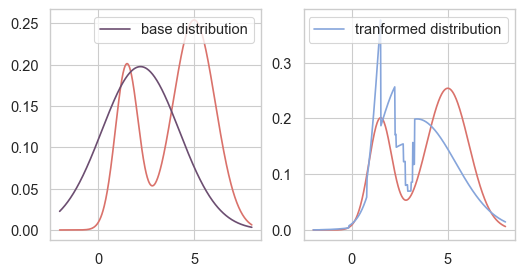

Iter 5000 --- NF Loss = 0.06658101081848145 (best so far)


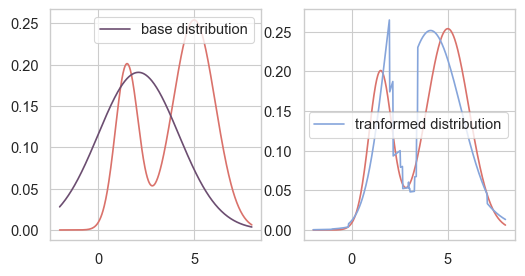

Iter 5500 --- NF Loss = 0.06158781051635742 (best so far)


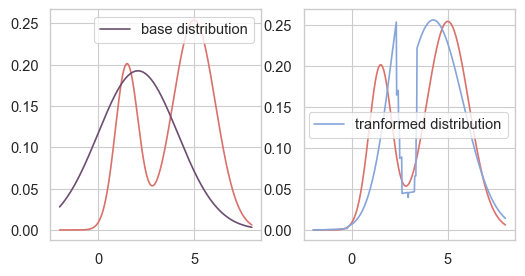

Iter 6000 --- NF Loss = 0.012645840644836426 (best so far)


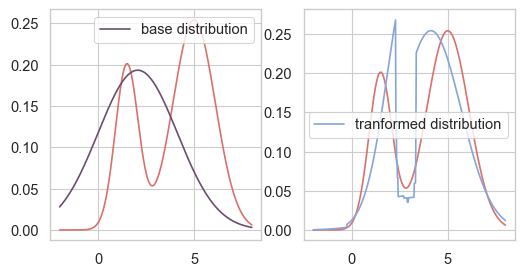

Iter 6500 --- NF Loss = 0.10584533214569092


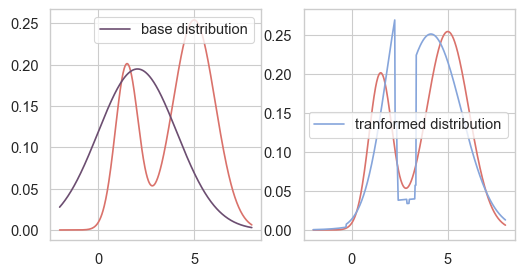

Iter 7000 --- NF Loss = 0.09086251258850098


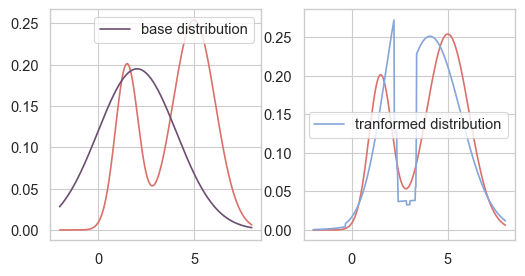

Iter 7500 --- NF Loss = 0.09312689304351807


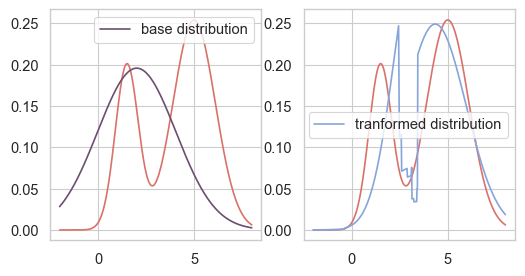

Iter 8000 --- NF Loss = 0.22526884078979492


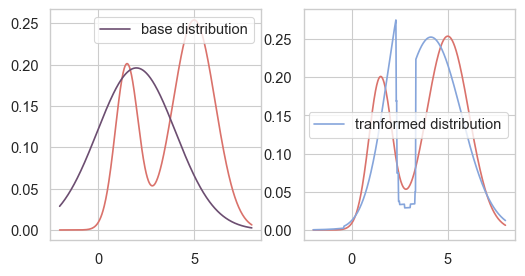

Iter 8500 --- NF Loss = 0.16253423690795898


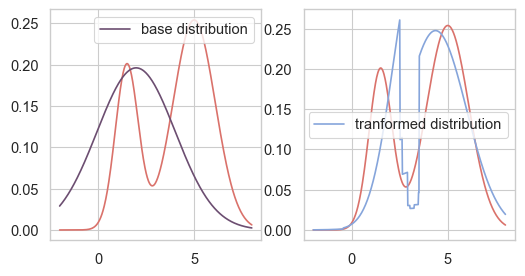

Iter 9000 --- NF Loss = 0.15924930572509766


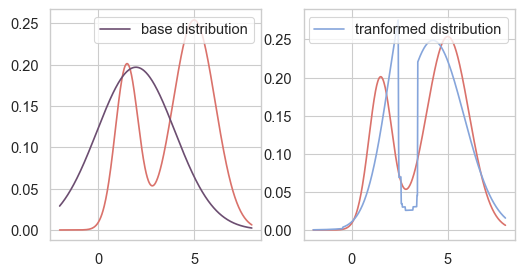

Iter 9500 --- NF Loss = 0.0024646520614624023 (best so far)


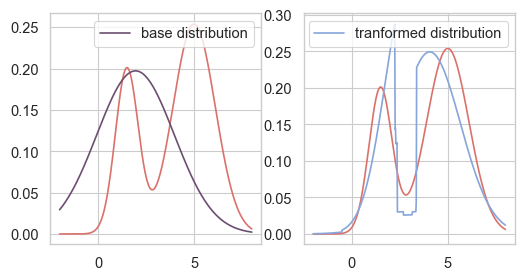

In [6]:
import torch, copy
import normflows as nf

U_SCALE = 1
num_flows = 16
num_params = 1
act = 'leaky_relu'
epochs = 10000
log_epoch = 500
lr = 5e-4
annealing = False#True
anneal_iter = 1000
num_samples_nf_train = 100
learn_base=True #False

torch.manual_seed(5)

my_palette = sns.color_palette([red_color, blue_color, purple_color])
# sns.set_theme(context='paper', style='whitegrid', palette=my_palette, font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_theme(context='paper', style='whitegrid', palette=my_palette, font='sans-serif', font_scale=1.2)
# TODO

flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_params,), act=act, u=U_SCALE*(2*torch.rand(num_params)-1))]
    # flows += [nf.flows.Radial((num_params,))]

# base distribution
q0 = nf.distributions.DiagGaussian(num_params, trainable=learn_base)
if learn_base:
    state_dict = q0.state_dict()
    state_dict['loc'] = torch.Tensor([(x_plot[0]+x_plot[-1])/2]).reshape(1,1)
    state_dict['log_scale'] = torch.Tensor([-0.5]).reshape(1,1)
    q0.load_state_dict(state_dict)
else:
    q0.loc = torch.Tensor([(x_plot[0]+x_plot[-1])/2]).reshape(1,1)
    q0.log_scale = torch.Tensor([-0.5]).reshape(1,1)

# set up normflow
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target_tr) 
# nfm.to(device)  # Move model on GPU if available

init_nfm = [torch.exp(nfm.log_prob(torch.Tensor([x]))).item() for x in x_plot]
init_base = [torch.exp(q0.log_prob(torch.Tensor([x]))).item() for x in x_plot]

optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
best_loss = 1000
for it in range(epochs):
    # optimize
    optimizer.zero_grad()
    if annealing:
        nf_loss = nfm.reverse_kld(num_samples_nf_train, beta=min([1., 0.01 + it / anneal_iter]))
    else:
        nf_loss = nfm.reverse_kld(num_samples_nf_train)
    assert not nf_loss.isinf(), it
    nf_loss.backward()
    optimizer.step()

    # plot at the beginning of the iteration
    if it%log_epoch==0:
        msg = 'Iter ' + str(it) +' --- NF Loss = ' + str(nf_loss.item())
        if nf_loss.item()<best_loss and not (annealing and it<anneal_iter):
            best_loss=nf_loss.item()
            best_nfm = copy.deepcopy(nfm)
            msg += ' (best so far)'
        print(msg)
        fig, axs = plt.subplots(1,2,figsize=(6 ,3))
        sns.lineplot(x=x_plot, y=target_np.pdf(x_plot), ax=axs[0], color=red_color)
        sns.lineplot(x=x_plot, y=target_np.pdf(x_plot), ax=axs[1], color=red_color)

        sns.lineplot(
            x=x_plot, 
            y=[torch.exp(q0.log_prob(torch.Tensor([x]))).item() for x in x_plot], 
            ax=axs[0], color=purple_color, label='base distribution'
        )
        sns.lineplot(
            x=x_plot, 
            y=[torch.exp(nfm.log_prob(torch.Tensor([x]))).item() for x in x_plot], 
            ax=axs[1], 
            color=blue_color, 
            label='tranformed distribution'
        )
        plt.show()
    
trained_nfm = [torch.exp(best_nfm.log_prob(torch.Tensor([x]))).item() for x in x_plot] 
trained_base = [torch.exp(best_nfm.q0.log_prob(torch.Tensor([x]))).item() for x in x_plot]


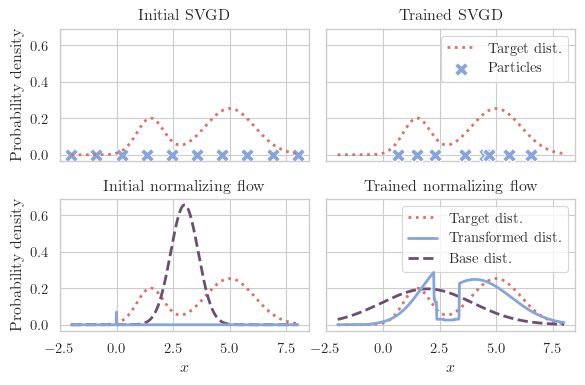

In [10]:
plt.rcParams['text.usetex'] = True

# redefine colors
hls_colors = sns.color_palette('hls')
# blue_color = hls_colors[3]
# red_color = hls_colors[0]
# purple_color = hls_colors[5]
red_linestyle = ':'
blue_linestyle = '-'
purple_linestyle = '--'

my_palette = sns.color_palette([red_color, blue_color, purple_color])
sns.set_theme(
    context='paper', style='whitegrid', palette=my_palette, 
    font="Times New Roman", font_scale=1.2) #, color_codes=True, rc=None
# 'sans-serif'
fig, axs = plt.subplots(2,2,figsize=(6, 4), sharey=True, sharex=True)
for row_ind, row_name in enumerate(['SVGD', 'normalizing flow']):
    for col_ind, col_name in enumerate(['Initial', 'Trained']):
        axs[row_ind, col_ind].set_title(f'{col_name} {row_name}')

# target
for i in range(2):
    sns.lineplot(
        x=x_plot, y=target_np.pdf(x_plot), ax=axs[i, 0], 
        linewidth=2, linestyle=red_linestyle, color=red_color
    )
    sns.lineplot(
        x=x_plot, y=target_np.pdf(x_plot), ax=axs[i, 1], 
        label='Target dist.', linewidth=2, linestyle=red_linestyle, color=red_color
    )

# SVGD particles
sns.scatterplot(
    x=x0.flatten(), y=np.zeros(num_particles), 
    ax=axs[0, 0], color=blue_color, marker='X', s=100
)

sns.scatterplot(
    x=theta.flatten(), y=np.zeros(num_particles), 
    ax=axs[0, 1], color=blue_color, marker='X', s=100, label='Particles', zorder=10
)

# normflow
# sns.lineplot(
#     x=x_plot, y=init_nfm, 
#     ax=axs[1, 0], color=blue_color, 
#     linewidth=2, linestyle=blue_linestyle, zorder=10
# )
axs[1, 0].plot(
    x_plot, init_nfm, color=blue_color, 
    linewidth=2, linestyle=blue_linestyle, zorder=10
)
sns.lineplot(
    x=x_plot, y=trained_nfm, 
    ax=axs[1, 1], color=blue_color, label='Transformed dist.', 
    linewidth=2, linestyle=blue_linestyle, zorder=10
)
sns.lineplot(
    x=x_plot, y=init_base, 
    ax=axs[1, 0], color=purple_color, 
    linewidth=2, linestyle=purple_linestyle, zorder=5
)
sns.lineplot(
    x=x_plot, y=trained_base, 
    ax=axs[1, 1], color=purple_color, label='Base dist.', 
    linewidth=2, linestyle=purple_linestyle, zorder=5
)


for ind in range(2):
    axs[ind, 1].legend(loc='upper right', frameon=True, fancybox=True, shadow=False)
    axs[ind, 0].set_ylabel('Probability density')
    axs[1, ind].set_xlabel(r'$x$')

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'experiments', '1D', 'svgd_1d.pdf'))

In [8]:
def _get_share_ax(share_var, axarr, row, col):
    if share_var=='row':
        if col > 0:
            return axarr[row, col-1]
        return None
    elif share_var=='col':
        if row > 0:
            return axarr[row-1, col]
        return None
    elif share_var and (col>0 or row>0):
        return axarr[0,0]
    return None

def subplots_with_row_titles(nrows, ncols, row_titles=None, row_title_kw=None, sharex=False, sharey=False, subplot_kw=None, grid_spec_kw=None, **fig_kw):
    """
    Creates a figure and array of axes with a title for each row.
    
    Parameters
    ----------
    nrows, ncols : int
        Number of rows/columns of the subplot grid
    row_titles : list, optional
        List of titles for each row. If included, there must be one title for each row.
    row_title_kw: dict, optional
        Dict with kewords passed to the `~matplotlib.Axis.set_title` function.
        A common use is row_title_kw={'fontsize': 24}
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:

        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.

        When subplots have a shared x-axis along a column, only the x tick
        labels of the bottom subplot are created. Similarly, when subplots
        have a shared y-axis along a row, only the y tick labels of the first
        column subplot are created. To later turn other subplots' ticklabels
        on, use `~matplotlib.axes.Axes.tick_params`.
    subplot_kw : dict, optional
        Dict with keywords passed to the
        `~matplotlib.figure.Figure.add_subplot` call used to create each
        subplot.
    gridspec_kw : dict, optional
        Dict with keywords passed to the `~matplotlib.gridspec.GridSpec`
        constructor used to create the grid the subplots are placed on.
    **fig_kw
        All additional keyword arguments are passed to the
        `.pyplot.figure` call.
    """
    if row_titles is not None and len(row_titles) != nrows:
        raise ValueError(f'If row_titles is specified, there must be one for each row. Got={row_titles}')
    if subplot_kw is None:
        subplot_kw = {}
    if row_title_kw is None:
        row_title_kw = {}
    if sharex not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharex must be one of [True, False, "row", "col"]. Got={sharex}')
    if sharey not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharey must be one of [True, False, "row", "col"]. Got={sharey}')
        
    fig, big_axes = plt.subplots(nrows, 1, **fig_kw)
    for (row, big_ax) in enumerate(big_axes):
        if row_titles is not None:
            big_ax.set_title(str(row_titles[row]), **row_title_kw)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax._frameon = False
        
    axarr = np.empty((nrows, ncols), dtype='O')
    for row in range(nrows):
        for col in range(ncols):
            sharex_ax = _get_share_ax(sharex, axarr, row, col)
            sharey_ax = _get_share_ax(sharex, axarr, row, col)
    
            ax= fig.add_subplot(nrows, ncols, row*ncols+col+1,
                                sharex=sharex_ax, sharey=sharey_ax, **subplot_kw)
            axarr[row, col] = ax
    return fig, axarr       
